# Импорты и кастомные функции

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import tables as tb
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True, n=2500)

def plot3D(X, target, elev=0, azim=0, title=None, sub=111):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    mappab = ax.scatter(x, y, z, c=target, cmap=CMAP)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

# Этот инструмент позволяет менять точку зрения
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(mappable=mappab, label='Target variable')
    plt.show()
    
feat_XY = ['TX', 'TY', 'X', 'Y']

def add_neighbours(df, k, metric='minkowski'):
    res = []
    
    for data_ind in tqdm(np.unique(df.data_ind)):
        ind = df.loc[df.data_ind == data_ind].copy()
        #как будет замечено, 1293 - это расстояние между слайсами по Z
        ind[['TX', 'TY']] *= 1293
        values = np.unique(ind.Z)
        
        for j in range(1, len(values)):
            z, z_next = (ind.loc[ind.Z == values[j-1]].copy(),
                         ind.loc[ind.Z == values[j]].copy())
            
            b_tree = BallTree(z_next[feat_XY], metric=metric)
            d, i = b_tree.query(z[feat_XY], k=min(k, len(z_next)))
            
            for m in range(i.shape[1]):
                data = z_next.iloc[i[:, m]]
                z_copy = z.copy()
                for col in feat_XY + ['Z']:
                    z_copy[col + '_pair'] = data[col].values
                res.append(z_copy)
            
        res.append(z_next)
        
    res = pd.concat(res)
    for col in feat_XY + ['Z']:
        res['d' + col] = res[col].values - res[col + '_pair'].values
    return res

def balance_train(df, k):
    data = add_neighbours(df, k=k)
    noise = data.event_id == -999
    signal, not_signal = data.loc[np.logical_not(noise)], data.loc[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)

# Загрузка данных

In [3]:
train = pd.read_hdf('reference/hdf5/open30.h5')
test = pd.concat([pd.read_hdf(file) for file in ['reference/test_close0.h5',
                                                 'reference/test_close10.h5']])

In [4]:
test = test.reset_index(drop=True)

In [5]:
test.head()

,TX,TY,X,Y,Z,data_ind
0,0.087240,0.119438,86536.218750,62988.312500,56892.0,0
1,-0.380208,0.198382,93346.765625,58062.937500,14223.0,0
2,-0.348549,-0.099981,66129.578125,23038.673828,46548.0,0
3,0.585342,-0.126879,68825.523438,55186.625000,45255.0,0
4,0.038579,-0.131510,36366.941406,47564.878906,9051.0,0


In [6]:
train.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind
0,-0.248382,0.072824,37014.070312,38318.898438,31032.0,-999.0,0.0,21
1,0.768548,0.490205,46626.425781,15151.117188,72408.0,188918.0,1.0,21
2,-0.132050,-0.049405,54031.640625,69132.320312,60771.0,-999.0,0.0,21
3,0.260584,0.207106,56653.531250,35025.765625,43962.0,-999.0,0.0,21
4,0.267597,0.111272,42231.714844,47199.027344,20688.0,-999.0,0.0,21


Посмотрим как выглядят ливни внутри одного data_ind

In [7]:
first = train.loc[train.data_ind == 21, :]

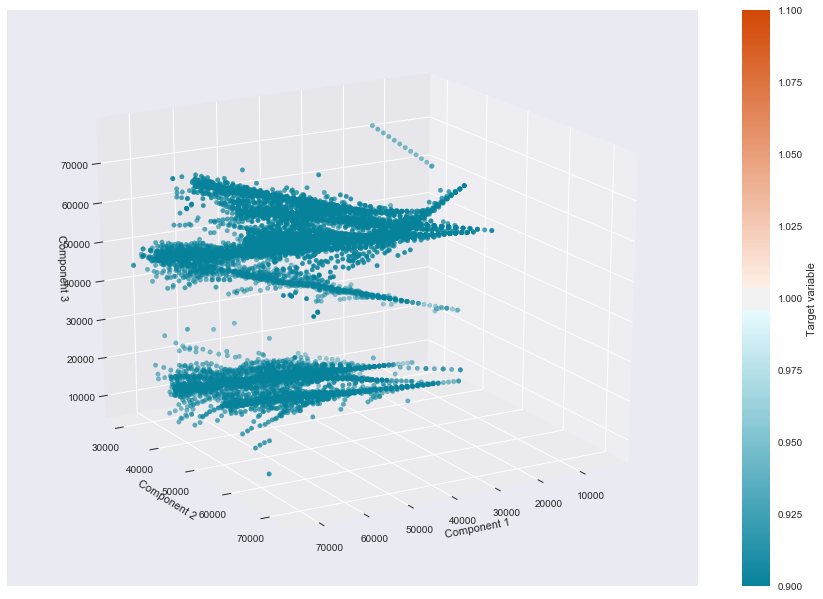

In [8]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=20, azim=60)

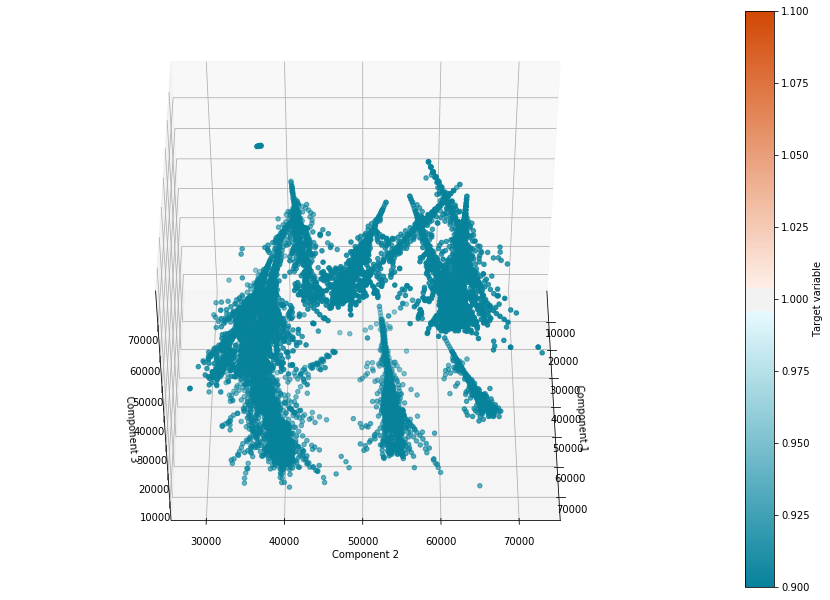

In [8]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=45, azim=0)

Глянем как распределены шум и сигнал вдоль осей

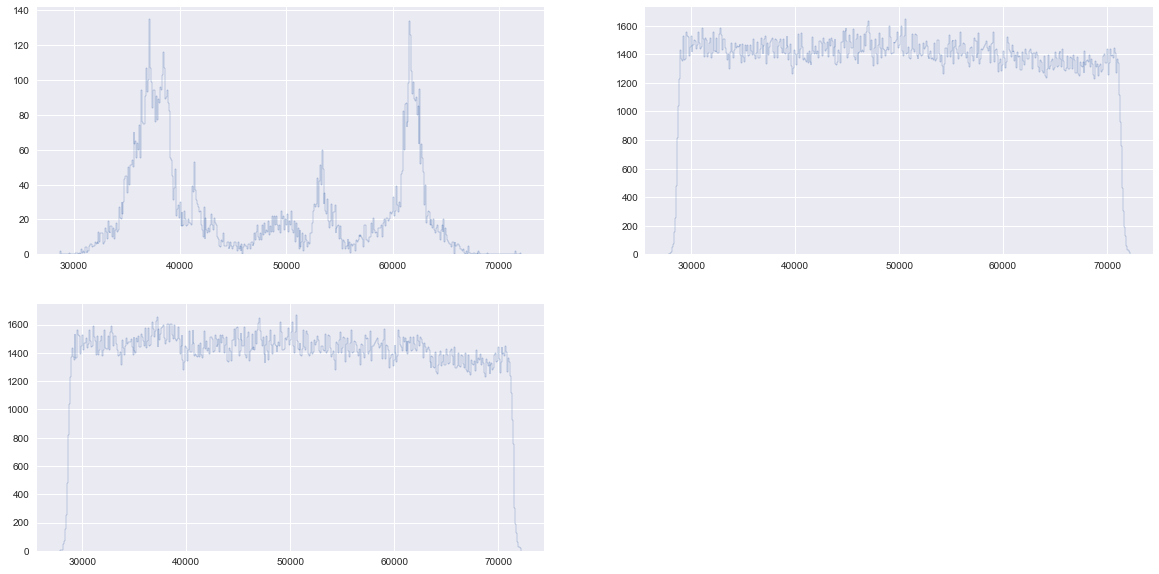

In [9]:
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

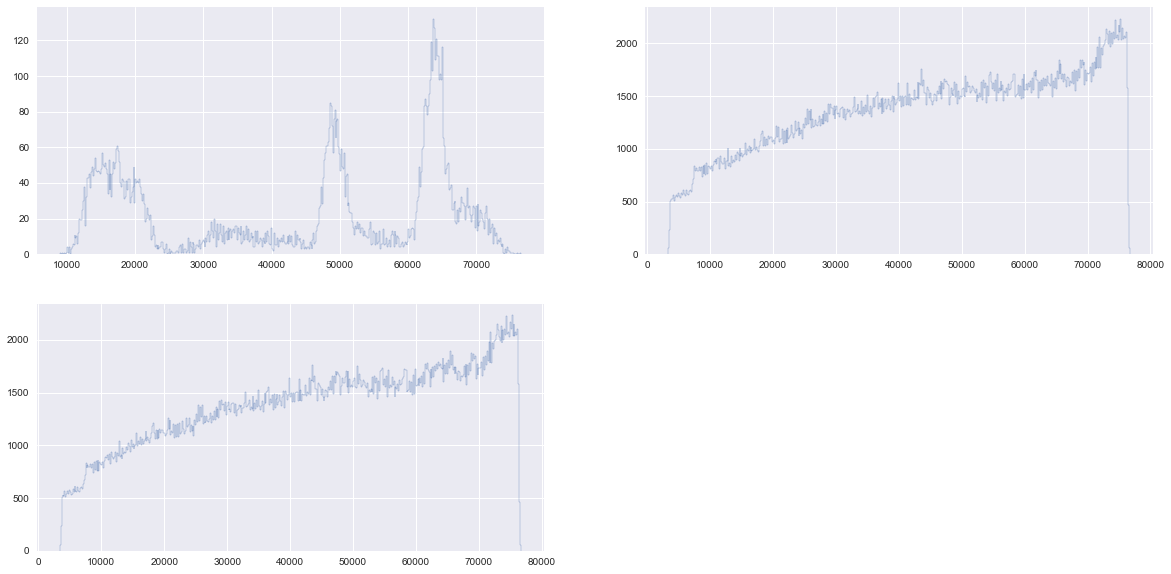

In [10]:
axis = 'Y'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

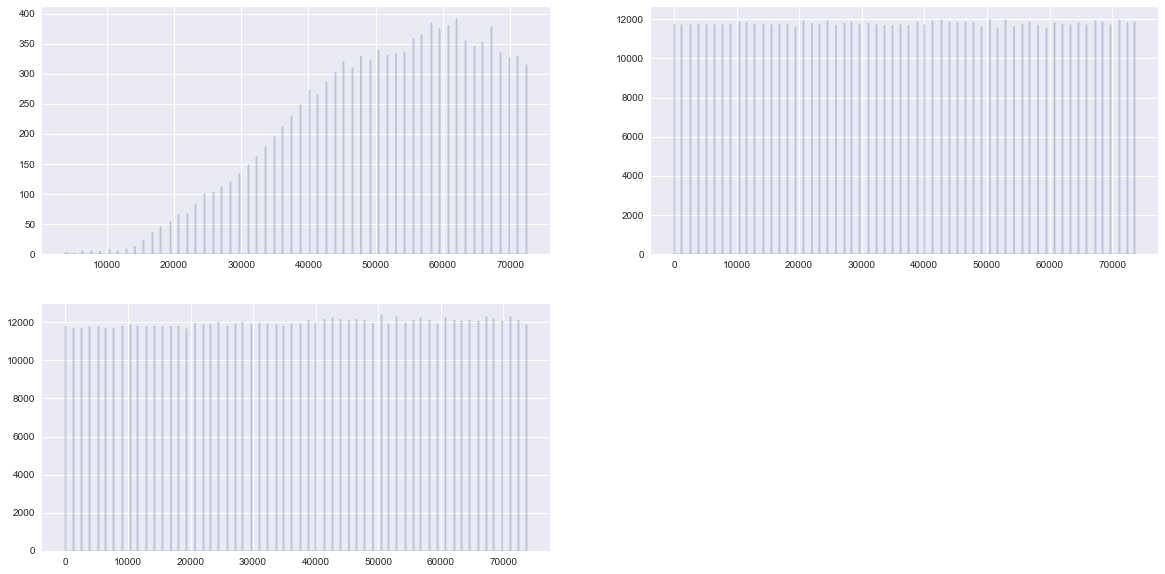

In [11]:
axis = 'Z'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

Интересно, что слайсы по z практически на одинаковом расстоянии. Посмотрим, что это за расстояние

In [12]:
np.array(sorted(np.unique(first.Z)))

array([     0.        ,   1293.        ,   2586.        ,   3879.        ,
         4154.88671875,   4158.16796875,   5172.        ,   6465.        ,
         7758.        ,   9051.        ,   9247.69726562,  10344.        ,
        10518.49414062,  11637.        ,  12930.        ,  14223.        ,
        15516.        ,  16809.        ,  16886.39257812,  18102.        ,
        19395.        ,  19432.52148438,  20688.        ,  20702.31445312,
        20707.76367188,  21977.375     ,  21981.        ,  23274.        ,
        24521.2578125 ,  24525.88867188,  24567.        ,  25860.        ,
        27069.26953125,  27153.        ,  28446.        ,  29739.        ,
        31032.        ,  32325.        ,  33618.        ,  34911.        ,
        35979.5859375 ,  36204.        ,  37497.        ,  38790.        ,
        40083.        ,  41376.        ,  42669.        ,  43962.        ,
        45255.        ,  46548.        ,  47841.        ,  49134.        ,
        50427.        ,  

Оказывается, что это расстояние 1293

# Группировка на пары

На семинаре мы обсуждали как группировать на пары, поэтому давайте провернём здесь этот номер (код выше)


In [14]:
train = []
for file in glob.glob('reference/hdf5/open*.h5')[:5]:
    train.append(balance_train(pd.read_hdf(file), k=3))
train = pd.concat(train)

100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


In [15]:
train.head()

,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,data_ind,event_id,signal,dTX,dTY,dX,dY,dZ
0,-90.693604,-101.512840,62.511978,58.599155,66553.140625,66560.398438,70413.304688,70408.304688,7758.000000,7972.021484,321,154753.0,1.0,10.819237,3.912823,-7.257812,5.000000,-214.021484
1,-101.512840,-89.733559,58.599155,56.895931,66560.398438,66462.164062,70408.304688,70474.039062,7972.021484,9051.000000,321,195860.0,1.0,-11.779282,1.703224,98.234375,-65.734375,-1078.978516
2,-101.512840,-124.778343,58.599155,321.037292,66560.398438,66483.375000,70408.304688,70340.359375,7972.021484,9051.000000,321,195860.0,1.0,23.265503,-262.438141,77.023438,67.945312,-1078.978516
3,-101.512840,153.110825,58.599155,498.680450,66560.398438,66636.484375,70408.304688,70315.125000,7972.021484,9051.000000,321,195860.0,1.0,-254.623657,-440.081299,-76.085938,93.179688,-1078.978516
4,-89.733559,494.405548,56.895931,769.021423,66462.164062,45275.574219,70474.039062,17773.132812,9051.000000,9244.753906,321,154753.0,1.0,-584.139099,-712.125488,21186.589844,52700.906250,-193.753906


# Построение модельки

In [16]:
y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind'], axis=1)

In [18]:
import os

# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xg
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [19]:
param_grid = {
        'n_estimators':[10], 
        'max_depth':[5],
}

class XGBClassifier_tmp(XGBClassifier):
    def predict(self, X):
        return XGBClassifier.predict_proba(self, X)[:, 1]

clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,
                                     colsample_bytree=0.8), 
                   param_grid=param_grid, n_jobs=1,
                   scoring='roc_auc',
                   cv=StratifiedKFold(3, shuffle=True, random_state=0),
                   verbose=7)

In [20]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=5, n_estimators=10 ....................................
[CV]  max_depth=5, n_estimators=10, score=0.8510851332930377, total= 3.2min
[CV] max_depth=5, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s


[CV]  max_depth=5, n_estimators=10, score=0.8553647604136178, total= 2.0min
[CV] max_depth=5, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min remaining:    0.0s


[CV]  max_depth=5, n_estimators=10, score=0.85367812897522, total= 3.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
         n_estimators=100, n_jobs=1, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10], 'max_depth': [5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=7)

In [21]:
clf.best_estimator_

XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
         n_estimators=10, n_jobs=1, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.8)

In [22]:
xgb_class = XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
         n_estimators=100, n_jobs=1, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.8)

# Предсказание

In [23]:
prepared_test = add_neighbours(test, k=3)
X_test = prepared_test.drop(['data_ind'], axis=1)

100%|██████████| 11/11 [00:53<00:00,  4.85s/it]


In [24]:
xgb_class.fit(X_train, y_train)
probas = xgb_class.predict(X_test)

In [25]:
df = pd.DataFrame({'id': prepared_test.index, 'signal': probas}).groupby('id')
agg = df.aggregate(('mean')).loc[:, ['signal']]

In [26]:
agg.shape

(7698899, 1)

In [27]:
agg.head()

,signal
id,
0,0.034087
1,0.004967
2,0.034750
3,0.245619
4,0.011468


In [28]:
agg.to_csv('submission/submit2.csv', index=True)